# Week 13: Poly Square Mapping as a whole
Consider both boundary classification & distortion

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [132]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import torch
from torch.optim import LBFGS
torch.set_printoptions(precision=10)

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices, retrieve_triangles_with_edge
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.pyvista_util import preprocess, postprocess

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Visualization
import pyvista as pv
from pyvista import examples
import torch
import torch.optim as optim

from scipy.spatial import Delaunay

<a name='1'></a>
## 1 - Test Example

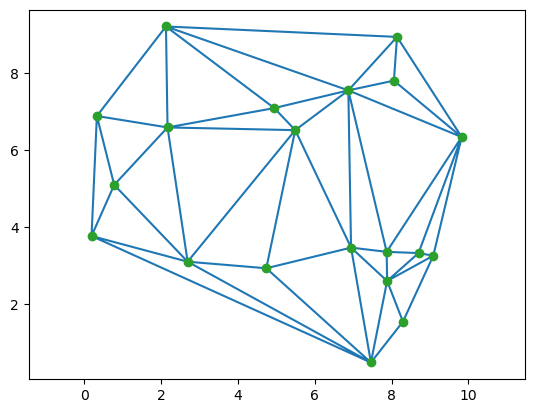

In [133]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

faces=tri.simplices.copy()
vertices=points.copy()

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

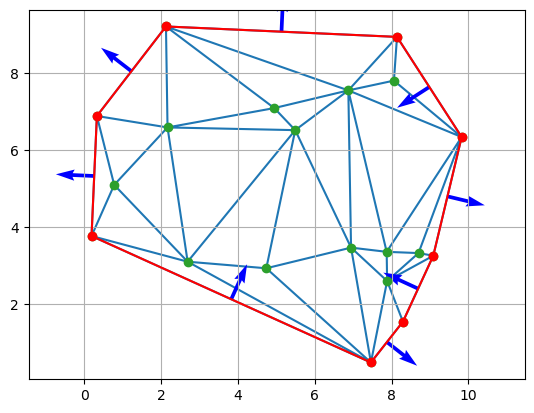

In [134]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


## New test

In [135]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            
            E_angle += self.activation(angle)
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)
        
#         for edge in self.BE_r_BV:
#             A, B = BV[edge[0]], BV[edge[1]]
#             E_align += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)

        return E_angle + E_align
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [136]:
def retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges):
    adjacent = {v: set() for v in boundary_vertices}

    for edge in boundary_edges:
        v1, v2 = edge
        if v1 in adjacent:
            adjacent[v1].add(v2)
        if v2 in adjacent:
            adjacent[v2].add(v1)

    result = [list(adjacent[v]) for v in boundary_vertices]

    return result

def retrieve_adjacent_vertices_with_boundary_vertex(boundary_vertices, boundary_edges):
    adjacent = retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges)
    result = [np.append(np.where(boundary_vertices==v1), np.where(boundary_vertices==v2)) for v1, v2 in adjacent]

    return np.array(result)

In [137]:
test = Chen_2023_scipy(vertices, faces)

In [138]:
x0 = np.ravel(test.solution[test.BV_r_V])
test.objective(x0)

19.046441407623167

In [139]:
test.optimize_default()

In [140]:
test.res.fun

5.64513316411661e-05

In [141]:
test.res

      fun: 5.64513316411661e-05
 hess_inv: array([[ 6.52708262e-04,  1.31245678e-05, -1.06441338e-03,
        -1.58222701e-06,  5.08637374e-05, -6.36597217e-05,
         5.26203753e-05, -2.05763720e-06, -1.09187043e-03,
         6.50540557e-05,  6.58591171e-04, -2.36629024e-05,
        -1.57846555e-03, -2.18696466e-06,  6.23873967e-04,
        -1.08665461e-05],
       [ 1.31245678e-05,  9.61286953e-01,  3.23028398e-03,
         1.61036785e-02, -9.32127448e-05, -1.85553450e-02,
        -9.97427437e-05,  1.60988116e-02,  3.31070536e-03,
         2.20981161e-02, -1.07755950e-05, -1.86243031e-02,
         4.78611228e-03,  1.08005920e-02,  1.34695731e-04,
         1.08447893e-02],
       [-1.06441338e-03,  3.23028398e-03,  2.42356717e-01,
         2.41514556e-02, -9.37168776e-03, -1.34669637e-02,
        -9.92820130e-03,  2.40311561e-02,  2.48435021e-01,
        -7.51659876e-03, -2.74342831e-03, -2.04762636e-02,
         3.59148967e-01, -4.14821431e-03,  8.68690157e-03,
        -1.02519336e

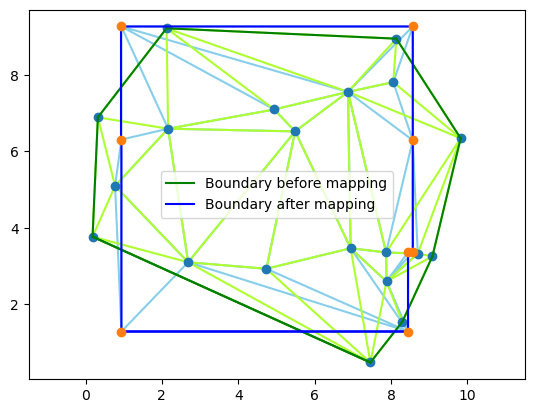

In [142]:
test.v_plt(show_origin=True, show_inner_edges=True, show_vertices=True, show_boundary_v=True)

# ---------------------------------------------------------------------

In [143]:
test.vertices == test_torch.vertices

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]])

In [190]:
class Chen_2023_pytorch:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100, learning_rate=0.001):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        self.loss = float('inf')
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        self.lr = learning_rate
        
        # Assuming that retrieve_boundary_* functions are available and compatible with PyTorch
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
        self.BV = torch.tensor(self.solution[self.BV_r_V], requires_grad=True, dtype=torch.float64
#                                , device='cuda'
                              )
        
    
    def activation(self, angle):
        if angle < (torch.pi/2):
            return torch.pow(torch.cos(angle), 2) / angle
        else:
            return torch.pow(torch.sin(2*angle), 2)
        
    def objective(self, BV):
        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = torch.norm(edge1)
            L2 = torch.norm(edge2)
            
            cos_theta = torch.dot(edge1, edge2) / (L1 * L2)
            angle = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))
            
            E_angle += self.activation(angle)
            E_align += L1 * (torch.sum(torch.abs(edge1 / L1)) - 1) + L2 * (torch.sum(torch.abs(edge2 / L2)) - 1)

        return E_angle + E_align
    
    # Assuming that Tutte_embedding_2D function is available and compatible with PyTorch
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    def optimize(self, lr=0.003, num_iter=100, tolerance=1e-1, loss_max=1):
        self.lr=lr
        self.max_iter=num_iter
        self.optimizer = LBFGS([self.BV], lr=self.lr)
        
        for i in range(num_iter):  
            loss = self.optimizer.step(self.closure)
            print(loss.item())
            if(self.loss - loss.item() < tolerance) or self.loss < loss_max:
                break
            self.loss = loss.item()

        self.solution[self.BV_r_V]=self.BV.detach().numpy()
        
    def closure(self):
        self.optimizer.zero_grad()
        loss = self.objective(self.BV)
        if(loss.item() > self.loss):
            return loss
        loss.backward()
        return loss

    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         self.solution[self.BV_r_V] = self.BV
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.BV.detach().numpy()
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [191]:
test_torch = Chen_2023_pytorch(vertices.copy(), faces.copy())

In [192]:
test_torch.optimize(
    lr=0.01, 
    tolerance=0.001)

19.046441407623167
15.330476793967163
15.25776330094423
15.180818527223925
15.098635243929781
15.009922184520995
14.913011116523458
14.805736647401922
14.685287840152103
14.548041763748884
14.389415618818017
14.24936687017189
14.235537079498123
14.221641555248556
14.20768012564788
14.193652621803928
14.1795588777553
14.165398730518863
14.151172020137404
14.136878589727246
14.12251828552585
14.108090956939522
14.093596456591026
14.079034640367187
14.064405367466595
14.049708500447132
14.034943905273531
14.020111451364903
14.005211011642235
13.990242462575797
13.975205684232517
13.960100560323255
13.944926978250066
13.929684829153228
13.914374007958436
13.898994413423647
13.883545948186036
13.868028518808579
13.852442035826865
13.836786413795476
13.8210615713344
13.805267431175295
13.789403920207597
13.77347096952445
13.75746851446853
13.741396494677709
13.725254854130513
13.709043541191393
13.692762508655926
13.676411713795794
13.659991118403433
13.643500688836745
13.626940396063352
13.

In [193]:
test_torch.mapping()

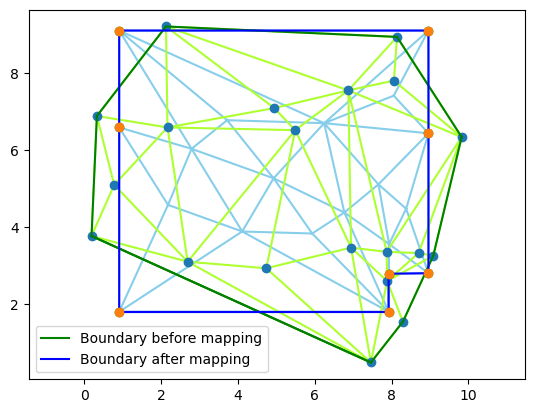

In [194]:
test_torch.v_plt(show_origin=True, show_inner_edges=True, show_vertices=True, show_boundary_v=True, show_BV=True)

# ------------------------------------------------------------------------------------------

In [326]:
import torch
from torch.optim import LBFGS

# 定义我们想要最小化的函数
def func(x):
    return (x - 2)**2

# 初始值 x0
x = torch.tensor([0.0], requires_grad=True)

# 使用L-BFGS优化器
optimizer = LBFGS([x], lr=0.01)

def closure():
    optimizer.zero_grad()
    output = func(x)
    output.backward()
    return output

In [129]:
# 迭代优化
for step in range(20):
    optimizer.step(closure)

print(f"Optimized value of x: {x.item()}")

Optimized value of x: 1.96391761302948
